# Parcial 3

### Enunciados Punto 1

Considere las bases de datos del petróleo brent (con nombre __petroleo_brent_historico.csv__) y de la tasa representativa del mercado (__trm_historico.csv__) que se encuentran en la carpeta DATOS del Google Drive.

1. Lea ambas bases de datos.

2. Una las dos bases de datos en una sola BD.

3. Realice un gráfico donde aparezcan ambas series de tiempo.

4. Ajuste un modelo de regresión con los errores descritos por medio de un proceso ARIMA.

5. Realice un diagnóstico del modelo y saque conclusiones.

6. Divida la BD en dos conjuntos: entrenamiento y prueba. Usted decide como dividir la serie de tiempo original en estos dos conjuntos.

7. Encuentre un modelo con la función __auto_arima__ para la BD de entrenamiento considerando Brent como variable exógena para explicar la TRM.

8. Realice un diagnóstico del modelo y saque conclusiones.

9. Realice predicciones y compare con los valores de la BD de prueba, utilizando el RMSE y el MAPE.

10. Saque conclusiones.

## 1. Lea ambas bases de datos.

In [372]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
 
import pmdarima as pmd
from scipy import stats

import warnings
warnings.filterwarnings("ignore")


def printfuller(test_res):
    """ null hypothesis is that a unit root is present in a time series sample."""
    print("Prueba de Dickey Fuller")
    print(f"The test statistic: \t {round(test_res[0], 10)}")
    print(f"p-value: \t \t {test_res[1]}")

plt.style.use('fivethirtyeight')

In [373]:
df = pd.read_csv("../data/petroleo_brent_historico.csv", decimal=",")
dolar = pd.read_csv("../data/trm_historico.csv")

In [374]:
df.Fecha = pd.to_datetime(df.Fecha, format="%d.%m.%Y")

In [375]:
df["fecha"] = df.Fecha
df["petroleo"] = df["Último"]

In [376]:
df = df[["fecha", "petroleo"]]

In [377]:
df.head()

,fecha,petroleo
0,2022-03-14,106.90
1,2022-03-11,112.67
2,2022-03-10,109.33
3,2022-03-09,111.14
4,2022-03-08,127.98


In [378]:
dolar.head()

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
0,2850.98,COP,09/10/2002,09/10/2002
1,2854.04,COP,10/10/2002,10/10/2002
2,2870.63,COP,11/10/2002,11/10/2002
3,2861.16,COP,12/10/2002,15/10/2002
4,2852.99,COP,16/10/2002,16/10/2002


In [379]:
dolar["fecha"] = pd.to_datetime(dolar.VIGENCIADESDE, format="%d/%m/%Y")
dolar["dolar"] = dolar.VALOR

In [380]:
dolar = dolar[["fecha", "dolar"]]

## 2. Una las dos bases de datos en una sola BD.

In [381]:
df = df.merge(dolar, on='fecha', how='left')
df = df.dropna()

In [382]:
df = df.sort_values(by=['fecha'])

## 3. Realice un gráfico donde aparezcan ambas series de tiempo.

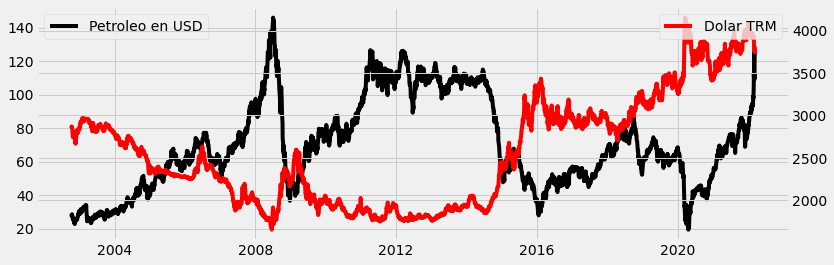

In [383]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()
ax1.plot(df.fecha, df.petroleo, color="black", label="Petroleo en USD")
ax2.plot(df.fecha, df.dolar, color="red", label="Dolar TRM")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

## 4. Ajuste un modelo de regresión con los errores descritos por medio de un proceso ARIMA.

In [384]:
import statsmodels.api as sm

In [385]:
df_2 = df.copy()

In [386]:
df_2["tendencia"] = list(range(0, 3632 + 1))

ValueError: Length of values (3633) does not match length of index (3637)

In [ ]:
df_2["mes"] = df.fecha.dt.month

In [ ]:
df_2["lag12"] = df.dolar.diff(periods = 12)

In [ ]:
df_2 = df_2.dropna()
mod_l = sm.OLS(df_2[["dolar"]], df_2[["tendencia", "mes", "lag12"]])

res = mod_l.fit()

print(res.summary())

**Se observa correlación entre el mes y la serie y no se presenta correlación de la serie con su valor 12 dias atras, por esta razon podria ser innecesario usar un Seasonal ARIMA.**

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
df.dolar.plot(ax=ax[0], title = "Serie de la TRM", xlabel="", color="black")
plot_acf(df.dolar, zero = False, title = "Función de autocorrelación", ax=ax[1])
plot_pacf(df.dolar, method="ywm", zero = False, title = "Función de autocorrelación parcial", ax=ax[2])
fig.show()

Del gráfico de la serie de tiempo no se observa que sea estacionaria, procedemos a observar la función de autocorrelación la cual presenta un decaimiento demasiado lento, por lo cual nos da indicios de que debemos de realizar una diferenciación.

Se realizará una prueba de Dickey-Fuller para verificar si es necesario realizar una diferenciación.

In [ ]:
test = adfuller(df.dolar)
printfuller(test)

Observando el p-valor = 0.8931232351189345 y con una significancia de $\alpha = 0.05$ no se rechaza. Esto quiere decir que no hay estacionaridad en la serie, lo que nos indica que debemos realizar una diferenciación.

Procedemos a diferenciar la serie. 

In [ ]:
dolar_diff = df.dolar.diff()
dolar_diff

In [ ]:
dolar_diff = dolar_diff[-dolar_diff.isna()]
dolar_diff

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
dolar_diff.plot(ax=ax[0], title = "Serie de la TRM diferenciada con un dia", xlabel="", color="black")
plot_acf(dolar_diff, zero = False, title = "Función de autocorrelación de la serie diferenciada", ax=ax[1])
plot_pacf(dolar_diff, method="ywm", zero = False, title = "Función de autocorrelación parcial de la serie diferenciada", ax=ax[2])
fig.show()

In [ ]:
test = adfuller(dolar_diff)
printfuller(test)

Observando el p-valor es menor a 0.05 por se rechaza la hipotesis nula. Esto quiere decir que hay estacionaridad en la serie con una diferenciación.

Despues de realizar la diferenciación se ve que en la ACF hay un corte en el Lag 1 y en la PACF hay un corte en el Lag 1 o 2, se entrenaran varios modelos.

In [ ]:
pdq_l = [(p, 1, q) for p in [0, 1, 2, 3] for q in [0, 1, 2, 3]] # ARIMA(0:3, 1, 0:3)

In [ ]:
filas = []
for order in pdq_l:
    fit = ARIMA(df.dolar, order=order).fit()
    aic = fit.aic
    bic = fit.bic
    filas.append([order, aic, bic])
filas

Nos decidimos a usar el modelo p = 0, d = 1, q = 2 ya que es el que tiene mejor (AIC, BIC) y ademas no tiene muchos parametros.

In [ ]:
df = df.reset_index(drop = True)

In [ ]:
df

In [ ]:
df_2[["dolar"]], df_2[["tendencia", "mes", "lag12"]]

In [ ]:
fit = ARIMA(df.dolar, order=(0,1,2)).fit()
fit.summary()

## 5. Realice un diagnóstico del modelo y saque conclusiones.

In [ ]:
sm.stats.acorr_ljungbox(fit.resid, lags=range(1, 10 + 1), return_df=True)

Como se puede observar en la tabla anterior, para los lags de 1 al 10 no se rechaza la hipótesis nula, esto quiere decir que hay una evidencia fuerte en contra de la hipótesis alternativa de correlación entre los errores. 

In [ ]:
fit.plot_diagnostics(figsize=(15,12))
plt.show()

Como se puede ver en el **summary** del punto anterior el modelo no cumple la normalidad en los errores, se intentaron varios modelos pero ninguno cumple normalidad, a pesar de esto el modelo se puede usar pero teniendo en cuenta que no se deben realizar predicciones muchos dias hacia el futuro. 

## 6. Divida la BD en dos conjuntos: entrenamiento y prueba. Usted decide como dividir la serie de tiempo original en estos dos conjuntos.



In [ ]:
df = df.dropna().reset_index(drop = True)

Creo la variable **pct_change** que es el cambio porcentual entre el precio del dia actual vs el precio de hace 7 dias.

In [ ]:
df["pct_change_1"] = df.petroleo.pct_change(periods = 1)
df["pct_change_2"] = df.petroleo.pct_change(periods = 2)
df["pct_change_3"] = df.petroleo.pct_change(periods = 3)
df["pct_change_4"] = df.petroleo.pct_change(periods = 4)

In [ ]:
df = df.dropna().reset_index(drop = True)

In [ ]:
df_len = df.shape[0]
df_len # numero de filas

In [ ]:
train = df[:(df_len - 10)]
test = df[(df_len - 10):]
test

In [ ]:
test

Utilizaremos solo 10 datos (2 semanas bursatiles) para el conjunto de prueba, ya que estos modelos usualmente no se usan para predecir muchos días en el futuro debido a la volatilidad, eventos inesperados y manipulación que estas series presentan.



Los datos de entrenamiento tienen 3623 filas (0 a 3622), los datos de prueba tienen 10 filas (3623 a 3632). 

## 7. Encuentre un modelo con la función auto_arima para la BD de entrenamiento considerando Brent como variable exógena para explicar la TRM.


In [ ]:
exo_var = ["petroleo", "pct_change_1", "pct_change_2", "pct_change_3", "pct_change_4"]
fit_X = pmd.arima.auto_arima(y = train["dolar"], X = train[exo_var])

In [ ]:
fit_X.summary()

Se puede observar que todas parecen ser significativas menos el cambio porcentual tres dias atras.

In [ ]:
pred_X, pred_ci = fit_X.predict(n_periods=10, X = test[exo_var], return_conf_int=True)

A continuación se observan los 7 valores al futuro predichos por el modelo.

In [ ]:
print(pred_X)

## 8. Realice un diagnóstico del modelo y saque conclusiones.

In [ ]:
fit_X.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
sm.stats.acorr_ljungbox(fit_X.resid())

Como se puede observar en el punto anterior se rechaza la normalidad de los errores y ademas se observa que no hay correlacion entre los errores del Lag 1 al 10.

## 9 . Realice predicciones y compare con los valores de la BD de prueba, utilizando el RMSE y el MAPE.

In [ ]:
pred_no_X = fit.predict(start = 3623, end = 3632)#3626 a 3632

- pred_X = Predicción hecha con variables exógenas.
- pred_no_X = Predicción hecha sin variables exógenas
- test.dolar = Valor real de la serie de prueba

In [ ]:
pred_no_X

In [ ]:
pred_X

In [ ]:
test.dolar

In [ ]:
MSE_X = mean_squared_error(test.dolar, pred_X)
MSE_no_X = mean_squared_error(test.dolar, pred_no_X)
MAPE_X = mean_absolute_percentage_error(test.dolar, pred_X)
MAPE_no_X = mean_absolute_percentage_error(test.dolar, pred_no_X)

print("Root Mean Square Error:")
print("- con variables exógenas " + str(math.sqrt(MSE_X)))
print("- sin variables exógenas " + str(math.sqrt(MSE_no_X)))

print("\n")
print("MAPE:")
print("- con variables exógenas " + str(MAPE_X*100))
print("- sin variables exógenas " + str(MAPE_no_X*100))

## 10. Saque conclusiones.

Se puede ver que con el **modelo entrenado inicialmente (sin variables exógenas)** se obtiene un **RMSE de 95.31 y un MAPE de 2.16**, mientras que cuando se consideran las **variables exógenas** de precio de petróleo y cambio porcentual respecto a días anteriores, se observa un **RMSE de 61.20 y un MAPE de 1.17**, esto es una reducción en el error de **alrededor del 50%**.

Si se tiene en cuenta que el dólar para la cola de esta base de datos toma valores alrededor de 3800, un RMSE de 61 se puede considerar aceptable o muy buena, depende mucho del uso que se le vaya a dar a estas predicciones. También se puede observar que agregar las variables exógenas si tuvo mejoría en las predicciones.

